In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/widsdatathon2024-challenge1/sample_submission.csv
/kaggle/input/widsdatathon2024-challenge1/training.csv
/kaggle/input/widsdatathon2024-challenge1/test.csv


In [2]:
X_train = pd.read_csv("/kaggle/input/widsdatathon2024-challenge1/training.csv")
X_test = pd.read_csv("/kaggle/input/widsdatathon2024-challenge1/test.csv")

In [3]:
## Function credit: https://www.kaggle.com/code/nkitgupta/advance-data-preprocessing 

def get_numerical_summary(df):
    total = df.shape[0]
    missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
    missing_percent = {}
    for col in missing_columns:
        null_count = df[col].isnull().sum()
        per = (null_count/total) * 100
        missing_percent[col] = per
        print("{} : {} ({}%)".format(col, null_count, round(per, 3)))
    return missing_percent

In [4]:
missing_percent = get_numerical_summary(X_test)

patient_race : 2901 (50.086%)
payer_type : 760 (13.122%)
patient_state : 21 (0.363%)
bmi : 4015 (69.32%)
metastatic_first_novel_treatment : 5781 (99.81%)
metastatic_first_novel_treatment_type : 5781 (99.81%)
Region : 21 (0.363%)
Division : 21 (0.363%)
family_size : 1 (0.017%)
family_dual_income : 1 (0.017%)
income_household_median : 1 (0.017%)
income_household_under_5 : 1 (0.017%)
income_household_5_to_10 : 1 (0.017%)
income_household_10_to_15 : 1 (0.017%)
income_household_15_to_20 : 1 (0.017%)
income_household_20_to_25 : 1 (0.017%)
income_household_25_to_35 : 1 (0.017%)
income_household_35_to_50 : 1 (0.017%)
income_household_50_to_75 : 1 (0.017%)
income_household_75_to_100 : 1 (0.017%)
income_household_100_to_150 : 1 (0.017%)
income_household_150_over : 1 (0.017%)
income_household_six_figure : 1 (0.017%)
home_ownership : 1 (0.017%)
home_value : 1 (0.017%)
rent_median : 1 (0.017%)
rent_burden : 1 (0.017%)
self_employed : 1 (0.017%)
farmer : 1 (0.017%)
poverty : 1 (0.017%)
limited_engli

In [5]:
#!pip install pgeocode
#import pgeocode 
#nomi = pgeocode.Nominatim('us') 

In [6]:
def zip_edit(zip_code):
    
    zip_str = str(zip_code) + '01'
    
    return zip_str

In [7]:
def get_long(zip_str):
    
    all_info = nomi.query_postal_code(zip_str)
    long = all_info.longitude
    
    return long

def get_lat(zip_str):
    
    all_info = nomi.query_postal_code(zip_str)
    lat = all_info.longitude
    
    return lat

In [8]:
#X_train['long'] = X_train.apply(lambda row : get_long(zip_edit(row['patient_zip3'])) , axis=1)

In [9]:
#X_train['lat'] = X_train.apply(lambda row : get_lat(zip_edit(row['patient_zip3'])) , axis=1)

In [10]:
#X_train_latlong = X_train # back up at this point as get_long and _lat functions very slow

In [11]:
# Drop cols with many missing values:

# metastatic_first_novel_treatment : 5781 (99.81%)
# metastatic_first_novel_treatment_type : 5781 (99.81%)

X_train = X_train.drop(['metastatic_first_novel_treatment_type','metastatic_first_novel_treatment'], axis = 1)
X_test = X_test.drop(['metastatic_first_novel_treatment','metastatic_first_novel_treatment_type'], axis = 1)


In [12]:
# remove patient_gender as only Females

X_train = X_train.drop(['patient_gender'], axis = 1)
X_test = X_test.drop(['patient_gender'], axis = 1)

There is a lot of consistency in the number of missing values for some categories of data, e.g. income-related columns all have one missing value. Suspect whole column categories missing from certain rows. Find and delete these.

In [13]:
pd.set_option('display.max_columns', None)
X_train.loc[X_train['income_household_median'].isnull()] 

X_train = X_train[X_train['income_household_median'].notna()]
missing_percent = get_numerical_summary(X_train) # Removes many NA instances but only reduces df by 4 rows 

patient_race : 6383 (49.473%)
payer_type : 1803 (13.975%)
patient_state : 51 (0.395%)
bmi : 8961 (69.454%)
Region : 52 (0.403%)
Division : 52 (0.403%)
Ozone : 29 (0.225%)
PM25 : 29 (0.225%)
N02 : 29 (0.225%)


In [14]:
y = X_train['DiagPeriodL90D']
X_train = X_train.drop(['DiagPeriodL90D'], axis = 1)

In [15]:
var_income = ['income_household_under_5','income_household_5_to_10','income_household_10_to_15','income_household_15_to_20',
            'income_household_20_to_25','income_household_25_to_35','income_household_35_to_50','income_household_50_to_75',
            'income_household_75_to_100','income_household_100_to_150','income_household_150_over']

X_train['income_household_variance'] = X_train[var_income].std(axis='columns')
X_test['income_household_variance'] = X_test[var_income].std(axis='columns')

X_train['sex_ratio'] = X_train['male'] / (X_train['female'] + X_train['male'])
X_test['sex_ratio'] = X_test['male'] / (X_test['female'] + X_test['male'])

X_train = X_train.drop(['male','female'], axis = 1)
X_test = X_test.drop(['male','female'], axis = 1)

X_train['young_pop'] = X_train['age_under_10'] + X_train['age_10_to_19']
X_train['working_pop'] = X_train['age_20s'] + X_train['age_30s'] + X_train['age_40s'] + X_train['age_50s']
X_train['retired_pop'] = X_train['age_60s'] + X_train['age_70s'] + X_train['age_over_80']

X_test['young_pop'] = X_test['age_under_10'] + X_test['age_10_to_19']
X_test['working_pop'] = X_test['age_20s'] + X_test['age_30s'] + X_test['age_40s'] + X_test['age_50s']
X_test['retired_pop'] = X_test['age_60s'] + X_test['age_70s'] + X_test['age_over_80']

In [16]:
#from sklearn.impute import SimpleImputer
#imp = SimpleImputer(strategy="mean")
#X_train["bmi"] = imp.fit_transform(X_train[["bmi"]]).ravel()

X_train['bin_bmi'] = pd.cut(x=X_train['bmi'], bins=[0, 18.5, 24.9, 29.9, 100],
                    labels=["underweight", "healthy_weight", "overweight", "obese"], ordered = False)
X_test['bin_bmi'] = pd.cut(x=X_test['bmi'], bins=[0, 18.5, 24.9, 29.9, 100],
                    labels=["underweight", "healthy_weight", "overweight", "obese"])

X_train['bin_bmi'] = X_train['bin_bmi'].astype('str')
X_test['bin_bmi'] = X_test['bin_bmi'].astype('str')

X_train = X_train.drop(['bmi'], axis = 1)
X_test = X_test.drop(['bmi'], axis = 1)

In [17]:
X_train.columns

Index(['patient_id', 'patient_race', 'payer_type', 'patient_state',
       'patient_zip3', 'patient_age', 'breast_cancer_diagnosis_code',
       'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code',
       'Region', 'Division', 'population', 'density', 'age_median',
       'age_under_10', 'age_10_to_19', 'age_20s', 'age_30s', 'age_40s',
       'age_50s', 'age_60s', 'age_70s', 'age_over_80', 'married', 'divorced',
       'never_married', 'widowed', 'family_size', 'family_dual_income',
       'income_household_median', 'income_household_under_5',
       'income_household_5_to_10', 'income_household_10_to_15',
       'income_household_15_to_20', 'income_household_20_to_25',
       'income_household_25_to_35', 'income_household_35_to_50',
       'income_household_50_to_75', 'income_household_75_to_100',
       'income_household_100_to_150', 'income_household_150_over',
       'income_household_six_figure', 'income_individual_median',
       'home_ownership', 'housing_units', 

In [18]:
X_train.head()

,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,Region,Division,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,income_household_variance,sex_ratio,young_pop,working_pop,retired_pop,bin_bmi
0,475714,NaN,MEDICAID,CA,924,84,C50919,Malignant neoplasm of unsp site of unspecified...,C7989,West,Pacific,31437.75000,1189.562500,30.642857,16.014286,15.542857,17.614286,14.014286,11.614286,11.557143,7.571429,4.000000,2.100000,36.571429,11.885714,47.114286,4.442857,3.928571,52.228571,52996.28571,3.142857,4.000000,6.157143,5.142857,6.271429,10.142857,13.300000,20.000000,12.742857,11.571429,7.528571,19.100000,24563.57143,44.585714,8674.500000,2.646343e+05,1165.000000,37.442857,33.257143,29.200000,25.914286,8.357143,3.257143,11.614286,39.557143,61.528571,8.471429,13.428571,0.000000,44.100000,13.100000,5.100000,1.485714,0.342857,27.114286,8.757143,66.685714,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,5.031920,0.498571,31.557143,54.800000,13.671429,nan
1,349367,White,COMMERCIAL,CA,928,62,C50411,Malig neoplm of upper-outer quadrant of right ...,C773,West,Pacific,39121.87879,2295.939394,38.200000,11.878788,13.354545,14.230303,13.418182,13.333333,14.060606,10.248485,5.951515,3.503030,50.245455,9.827273,35.290909,4.651515,3.622727,61.736364,102741.63640,2.327273,1.536364,2.648485,2.178788,2.409091,5.163636,7.972727,13.936364,12.469697,19.760606,29.596970,49.357576,41287.27273,61.463636,11725.666670,6.776885e+05,2003.125000,34.753125,14.230303,19.987879,29.796970,23.739394,12.245455,35.984848,47.918182,65.230303,5.103030,15.224242,0.027273,54.030303,2.527273,20.827273,0.587879,0.300000,11.645455,10.081818,37.948485,8.957576,10.109091,8.057576,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179,9.070040,0.498939,25.233333,55.042424,19.703030,overweight
2,138632,White,COMMERCIAL,TX,760,43,C50112,Malignant neoplasm of central portion of left ...,C773,South,West South Central,21996.68333,626.236667,37.906667,13.028333,14.463333,12.531667,13.545000,12.860000,12.770000,11.426667,6.565000,2.811667,55.753333,12.330000,27.195000,4.710000,3.260667,55.801667,85984.74138,2.483333,1.305000,2.716667,2.938333,2.766667,6.763333,12.061667,15.835000,13.560000,20.875000,18.680000,39.555000,40399.03333,72.745000,7786.583333,2.377131e+05,1235.907407,29.358491,10.811667,27.038333,32.368333,19.678333,10.115000,29.793333,37.308475,66.428333,4.560000,13.722034,3.650847,75.820000,9.231667,3.618333,0.463333,0.146667,3.816667,6.898333,19.370000,11.253333,9.663333,3.356667,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351,7.302572,0.501233,27.491667,51.706667,20.803333,obese
3,617843,White,COMMERCIAL,CA,926,45,C50212,Malig neoplasm of upper-inner quadrant of left...,C773,West,Pacific,32795.32558,1896.220930,42.871429,10.071429,12.135714,12.538095,12.464286,12.650000,14.847619,12.280952,8.216667,4.759524,52.604762,11.623810,31.142857,4.623810,3.098095,54.564

In [19]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

numeric_columns = X_train.select_dtypes(include='number').columns
X_train_num = X_train[numeric_columns]

imputer = IterativeImputer(random_state=100, max_iter=10)
df_imputed = imputer.fit_transform(X_train_num)
X_train[numeric_columns] = df_imputed

X_test_num = X_test[numeric_columns]

df_imputed_test = imputer.transform(X_test_num)
X_test[numeric_columns] = df_imputed_test

In [20]:
missing_percent = get_numerical_summary(X_test)

patient_race : 2901 (50.086%)
payer_type : 760 (13.122%)
patient_state : 21 (0.363%)
Region : 21 (0.363%)
Division : 21 (0.363%)


In [21]:
X_train['Imp_Race'] = X_train['patient_race'].fillna(X_train[['race_asian','race_black','race_white',
                                                         'race_native', 'race_pacific', 'race_other',
                                                        'hispanic']].idxmax(axis=1))
X_test['Imp_Race'] = X_test['patient_race'].fillna(X_test[['race_asian','race_black','race_white',
                                                         'race_native', 'race_pacific', 'race_other',
                                                        'hispanic']].idxmax(axis=1))

In [22]:
ids = {'race_pre':['hispanic','race_white','race_black', 'race_asian', 'race_native'],
      'race':['Hispanic','White','Black', 'Asian', 'Other']}

ids = dict(zip(ids['race_pre'], ids['race']))

X_train['Imp_Race'] = X_train['Imp_Race'].replace(ids, regex=True)
X_test['Imp_Race'] = X_test['Imp_Race'].replace(ids, regex=True)

X_train = X_train.drop(['patient_race'], axis = 1)
X_test = X_test.drop(['patient_race'], axis = 1)

In [23]:
X_train.payer_type = X_train.payer_type.fillna('Unknown')
X_test.payer_type = X_test.payer_type.fillna('Unknown')

In [24]:
X_train.head()

,patient_id,payer_type,patient_state,patient_zip3,patient_age,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,Region,Division,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,income_household_variance,sex_ratio,young_pop,working_pop,retired_pop,bin_bmi,Imp_Race
0,475714.0,MEDICAID,CA,924.0,84.0,C50919,Malignant neoplasm of unsp site of unspecified...,C7989,West,Pacific,31437.75000,1189.562500,30.642857,16.014286,15.542857,17.614286,14.014286,11.614286,11.557143,7.571429,4.000000,2.100000,36.571429,11.885714,47.114286,4.442857,3.928571,52.228571,52996.28571,3.142857,4.000000,6.157143,5.142857,6.271429,10.142857,13.300000,20.000000,12.742857,11.571429,7.528571,19.100000,24563.57143,44.585714,8674.500000,2.646343e+05,1165.000000,37.442857,33.257143,29.200000,25.914286,8.357143,3.257143,11.614286,39.557143,61.528571,8.471429,13.428571,0.000000,44.100000,13.100000,5.100000,1.485714,0.342857,27.114286,8.757143,66.685714,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,5.031920,0.498571,31.557143,54.800000,13.671429,nan,Hispanic
1,349367.0,COMMERCIAL,CA,928.0,62.0,C50411,Malig neoplm of upper-outer quadrant of right ...,C773,West,Pacific,39121.87879,2295.939394,38.200000,11.878788,13.354545,14.230303,13.418182,13.333333,14.060606,10.248485,5.951515,3.503030,50.245455,9.827273,35.290909,4.651515,3.622727,61.736364,102741.63640,2.327273,1.536364,2.648485,2.178788,2.409091,5.163636,7.972727,13.936364,12.469697,19.760606,29.596970,49.357576,41287.27273,61.463636,11725.666670,6.776885e+05,2003.125000,34.753125,14.230303,19.987879,29.796970,23.739394,12.245455,35.984848,47.918182,65.230303,5.103030,15.224242,0.027273,54.030303,2.527273,20.827273,0.587879,0.300000,11.645455,10.081818,37.948485,8.957576,10.109091,8.057576,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179,9.070040,0.498939,25.233333,55.042424,19.703030,overweight,White
2,138632.0,COMMERCIAL,TX,760.0,43.0,C50112,Malignant neoplasm of central portion of left ...,C773,South,West South Central,21996.68333,626.236667,37.906667,13.028333,14.463333,12.531667,13.545000,12.860000,12.770000,11.426667,6.565000,2.811667,55.753333,12.330000,27.195000,4.710000,3.260667,55.801667,85984.74138,2.483333,1.305000,2.716667,2.938333,2.766667,6.763333,12.061667,15.835000,13.560000,20.875000,18.680000,39.555000,40399.03333,72.745000,7786.583333,2.377131e+05,1235.907407,29.358491,10.811667,27.038333,32.368333,19.678333,10.115000,29.793333,37.308475,66.428333,4.560000,13.722034,3.650847,75.820000,9.231667,3.618333,0.463333,0.146667,3.816667,6.898333,19.370000,11.253333,9.663333,3.356667,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351,7.302572,0.501233,27.491667,51.706667,20.803333,obese,White
3,617843.0,COMMERCIAL,CA,926.0,45.0,C50212,Malig neoplasm of upper-inner quadrant of left...,C773,West,Pacific,32795.32558,1896.220930,42.871429,10.071429,12.135714,12.538095,12.464286,12.650000,14.847619,12.280952,8.216667,4.759524,52.604762,11.623810,31.142857,4.623

In [25]:
from sklearn.impute import SimpleImputer

cat_columns = ['patient_state','Region','Division']
cat_Imputer = SimpleImputer(strategy='most_frequent')

X_train[cat_columns] = pd.DataFrame(cat_Imputer.fit_transform(X_train[cat_columns]), columns=cat_columns)
X_test[cat_columns] = pd.DataFrame(cat_Imputer.transform(X_test[cat_columns]), columns=cat_columns)

In [26]:
### Code taken from: https://www.kaggle.com/code/vrushalimanka/wids-datathon-eda-baseline-model#2.-Exploratory-Data-Analysis- 

# load statmodels functions
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# compute the vif for all given features
def compute_vif(considered_features):
    
    X = X_train[considered_features].dropna()
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    
    vif = pd.DataFrame(vif).sort_values('VIF', ascending=False)
    
    return vif

corr_df = X_train.drop(['patient_id'],axis=1).select_dtypes(exclude=['object','category']).corr()
# only looking at correlations showing a coefficient higher than 0.01
corr_df = corr_df[abs(corr_df)>0.005].dropna(how='any',axis=0)
corr_df = corr_df[abs(corr_df)>0.005].dropna(how='any',axis=1)

# features to consider removing
considered_features = list(corr_df.index)

# compute vif 
#compute_vif(considered_features).sort_values('VIF', ascending=False)

# Remove variable with highest VIF and repeat until all below 5

In [27]:
vif = compute_vif(considered_features)

/opt/conda/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [28]:

def remove_high_vif(considered_features, vif): # need to run compute_vif once before running this function
    
    while vif.iloc[0,1] > 5:
        
        drop = vif.iloc[0,0]
        vif = vif.iloc[1: , :]
        considered_features = list(vif.iloc[:,0])

        vif = compute_vif(considered_features)
    
    return vif
        

In [29]:
vif_final = remove_high_vif(considered_features, vif)

In [30]:
vif_features = list(vif_final.iloc[:,0])

In [31]:
X_train_num = X_train[vif_features]

cat_cols = X_train.select_dtypes(include=['object','category']).columns
X_train_cat = X_train[cat_cols]

X_test_num = X_test[vif_features]

cat_cols = X_test.select_dtypes(include=['object','category']).columns
X_test_cat = X_test[cat_cols]

In [32]:
X_train.head()

,patient_id,payer_type,patient_state,patient_zip3,patient_age,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,Region,Division,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,income_household_variance,sex_ratio,young_pop,working_pop,retired_pop,bin_bmi,Imp_Race
0,475714.0,MEDICAID,CA,924.0,84.0,C50919,Malignant neoplasm of unsp site of unspecified...,C7989,West,Pacific,31437.75000,1189.562500,30.642857,16.014286,15.542857,17.614286,14.014286,11.614286,11.557143,7.571429,4.000000,2.100000,36.571429,11.885714,47.114286,4.442857,3.928571,52.228571,52996.28571,3.142857,4.000000,6.157143,5.142857,6.271429,10.142857,13.300000,20.000000,12.742857,11.571429,7.528571,19.100000,24563.57143,44.585714,8674.500000,2.646343e+05,1165.000000,37.442857,33.257143,29.200000,25.914286,8.357143,3.257143,11.614286,39.557143,61.528571,8.471429,13.428571,0.000000,44.100000,13.100000,5.100000,1.485714,0.342857,27.114286,8.757143,66.685714,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,5.031920,0.498571,31.557143,54.800000,13.671429,nan,Hispanic
1,349367.0,COMMERCIAL,CA,928.0,62.0,C50411,Malig neoplm of upper-outer quadrant of right ...,C773,West,Pacific,39121.87879,2295.939394,38.200000,11.878788,13.354545,14.230303,13.418182,13.333333,14.060606,10.248485,5.951515,3.503030,50.245455,9.827273,35.290909,4.651515,3.622727,61.736364,102741.63640,2.327273,1.536364,2.648485,2.178788,2.409091,5.163636,7.972727,13.936364,12.469697,19.760606,29.596970,49.357576,41287.27273,61.463636,11725.666670,6.776885e+05,2003.125000,34.753125,14.230303,19.987879,29.796970,23.739394,12.245455,35.984848,47.918182,65.230303,5.103030,15.224242,0.027273,54.030303,2.527273,20.827273,0.587879,0.300000,11.645455,10.081818,37.948485,8.957576,10.109091,8.057576,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179,9.070040,0.498939,25.233333,55.042424,19.703030,overweight,White
2,138632.0,COMMERCIAL,TX,760.0,43.0,C50112,Malignant neoplasm of central portion of left ...,C773,South,West South Central,21996.68333,626.236667,37.906667,13.028333,14.463333,12.531667,13.545000,12.860000,12.770000,11.426667,6.565000,2.811667,55.753333,12.330000,27.195000,4.710000,3.260667,55.801667,85984.74138,2.483333,1.305000,2.716667,2.938333,2.766667,6.763333,12.061667,15.835000,13.560000,20.875000,18.680000,39.555000,40399.03333,72.745000,7786.583333,2.377131e+05,1235.907407,29.358491,10.811667,27.038333,32.368333,19.678333,10.115000,29.793333,37.308475,66.428333,4.560000,13.722034,3.650847,75.820000,9.231667,3.618333,0.463333,0.146667,3.816667,6.898333,19.370000,11.253333,9.663333,3.356667,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351,7.302572,0.501233,27.491667,51.706667,20.803333,obese,White
3,617843.0,COMMERCIAL,CA,926.0,45.0,C50212,Malig neoplasm of upper-inner quadrant of left...,C773,West,Pacific,32795.32558,1896.220930,42.871429,10.071429,12.135714,12.538095,12.464286,12.650000,14.847619,12.280952,8.216667,4.759524,52.604762,11.623810,31.142857,4.623

In [33]:
X_train = pd.concat([X_train_num, X_train_cat], axis=1).reindex(X_train_num.index)
X_test = pd.concat([X_test_num, X_test_cat], axis=1).reindex(X_test_num.index)

In [34]:
missing_percent = get_numerical_summary(X_test)

In [35]:
bc_diag_desc = X_train['breast_cancer_diagnosis_desc'].unique()

print(bc_diag_desc)

['Malignant neoplasm of unsp site of unspecified female breast'
 'Malig neoplm of upper-outer quadrant of right female breast'
 'Malignant neoplasm of central portion of left female breast'
 'Malig neoplasm of upper-inner quadrant of left female breast'
 'Malignant neoplasm of breast (female), unspecified'
 'Malignant neoplasm of unspecified site of left female breast'
 'Malig neoplasm of lower-outer quadrant of left female breast'
 'Malignant neoplasm of upper-outer quadrant of female breast'
 'Malig neoplasm of upper-outer quadrant of left female breast'
 'Malignant neoplasm of ovrlp sites of left female breast'
 'Malignant neoplasm of unsp site of right female breast'
 'Malig neoplasm of lower-inner quadrant of left female breast'
 'Malig neoplm of lower-inner quadrant of right female breast'
 'Malignant neoplasm of central portion of right female breast'
 'Malignant neoplasm of central portion of female breast'
 'Malignant neoplasm of breast of unspecified site, female'
 'Malignant

In [36]:
lookup_dict = {"Malig " : "Malignant ", "neoplm " : "neoplasm ", "ovrlp " : "overlapping ", 
              "unsp " : "unspecified ", "site " : "sites " , "neoplasmof" : "neoplasm of "}


In [37]:
for old, new in lookup_dict.items():
    X_train['breast_cancer_diagnosis_desc'] = X_train['breast_cancer_diagnosis_desc'].str.replace(old, new, regex=False)
    X_test['breast_cancer_diagnosis_desc'] = X_test['breast_cancer_diagnosis_desc'].str.replace(old, new, regex=False)

In [38]:
bc_diag_desc = X_train['breast_cancer_diagnosis_desc'].unique()

#print(bc_diag_desc)

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
v = vectorizer.fit_transform(X_train['breast_cancer_diagnosis_desc'])
v_test = vectorizer.transform(X_test['breast_cancer_diagnosis_desc'])

In [40]:
bow = pd.DataFrame(v.toarray(), columns=vectorizer.get_feature_names_out())
bow = bow.drop(['and','breast','male','malignant','neoplasm','of','other','overlapping', 'portion', 'quadrant', 'site','sites','tail'], axis = 1)

X_train = pd.concat([X_train, bow], axis=1).reindex(X_train.index)
X_train = X_train.drop(['breast_cancer_diagnosis_desc'], axis = 1)

X_test = pd.concat([X_test, bow], axis=1).reindex(X_test.index)
X_test = X_test.drop(['breast_cancer_diagnosis_desc'], axis = 1)

In [41]:
X_train.drop(X_train.tail(4).index,
        inplace = True)
y.drop(y.tail(4).index,
        inplace = True)

In [42]:
missing_percent = get_numerical_summary(X_train)

In [43]:
numeric_columns = X_train.select_dtypes(include='number').columns
X_train_num = X_train[numeric_columns]
X_test_num = X_test[numeric_columns]

from sklearn import preprocessing

x = X_train_num.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X_train_scaled = pd.DataFrame(x_scaled, columns = X_train_num.columns)
X_train[numeric_columns] = X_train_scaled

x = X_test_num.values #returns a numpy array
x_scaled = min_max_scaler.transform(x)
X_test_scaled = pd.DataFrame(x_scaled, columns = X_test_num.columns)
X_test[numeric_columns] = X_test_scaled

In [44]:
X_test.head()

,age_60s,age_70s,income_household_100_to_150,widowed,housing_units,limited_english,income_household_35_to_50,income_household_15_to_20,race_asian,age_over_80,family_size,commute_time,unemployment_rate,education_some_college,self_employed,age_under_10,patient_zip3,health_uninsured,age_50s,rent_burden,sex_ratio,race_pacific,payer_type,patient_state,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_code,Region,Division,bin_bmi,Imp_Race,areola,axillary,central,female,inner,left,lower,nipple,outer,right,secondary,specified,unspecified,upper
0,0.236231,0.295321,0.405007,0.196077,0.071727,0.036231,0.488665,0.237624,0.006083,0.113111,0.322372,0.351374,0.159784,0.506825,0.360583,0.603199,0.407572,0.334262,0.572601,0.105319,0.431078,0.000656,MEDICAID,IN,C50412,C773,Midwest,East North Central,nan,White,0.0,0.0,0.000000,0.597701,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,1.000000,0.000000
1,0.392191,0.522789,0.375543,0.280341,0.322201,0.106030,0.505851,0.270108,0.069285,0.312003,0.226114,0.323175,0.258498,0.535714,0.399627,0.228854,0.262806,0.323945,0.587013,0.285125,0.454125,0.005212,COMMERCIAL,FL,C50912,C787,South,South Atlantic,nan,White,0.0,0.0,0.000000,0.501507,0.000000,0.000000,0.0,0.0,0.922303,0.774879,0.0,0.0,0.000000,0.922303
2,0.199260,0.160295,0.571949,0.117284,0.481999,0.476384,0.353850,0.144659,0.512843,0.135648,0.693268,0.564401,0.332419,0.513891,0.577701,0.488742,0.908686,0.191954,0.414064,0.279237,0.426385,0.018265,MEDICAID,CA,C50911,C773,West,Pacific,nan,Hispanic,0.0,0.0,0.949639,0.394969,0.000000,0.614794,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
3,0.199260,0.160295,0.571949,0.117284,0.481999,0.476384,0.353850,0.144659,0.512843,0.135648,0.693268,0.564401,0.332419,0.513891,0.577701,0.488742,0.908686,0.191954,0.414064,0.279237,0.426385,0.018265,MEDICARE ADVANTAGE,CA,C50912,C779,West,Pacific,nan,Hispanic,0.0,0.0,0.000000,0.455986,0.932274,0.709770,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.838588
4,0.109246,0.113279,0.349077,0.107356,0.495223,0.550832,0.378282,0.264686,0.254826,0.140670,0.550272,0.513189,0.486128,0.327699,0.815070,0.364711,0.889755,0.314475,0.338114,0.324294,0.493064,0.009903,Unknown,CA,C50412,C779,West,Pacific,healthy_weight,Black,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.836539,0.000000


In [45]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y, test_size=0.2, random_state=0, stratify=y)

In [46]:
X_train = X_train.drop(['nipple','secondary'], axis = 1)
X_val = X_val.drop(['nipple','secondary'], axis = 1)
X_test = X_test.drop(['nipple','secondary'], axis = 1)

In [47]:
from xgboost import XGBClassifier

model = XGBClassifier(enable_categorical = True)

cat_cols = X_train.select_dtypes(include=['object','category']).columns

# Convert categorical columns to category type
for col in cat_cols:
    X_train[col] = X_train[col].astype('category')
    X_val[col] = X_val[col].astype('category')
    X_test[col] = X_test[col].astype('category')

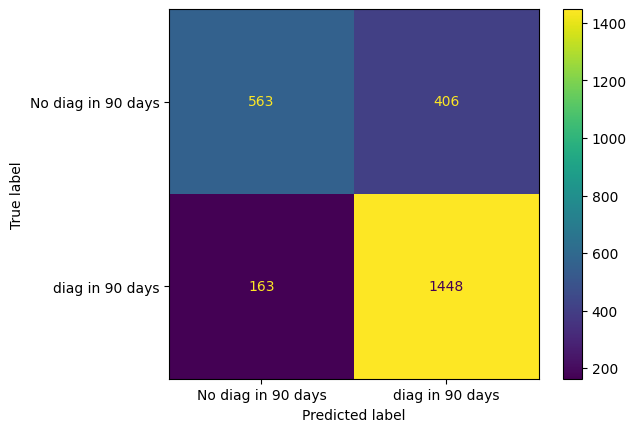

In [48]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import  confusion_matrix
import matplotlib.pyplot as plt

model.fit(X_train, y_train)

predictions_xgb = model.predict(X_val)

cm_xgb = confusion_matrix(y_val, predictions_xgb)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['No diag in 90 days', 'diag in 90 days'])
disp.plot()
plt.show()

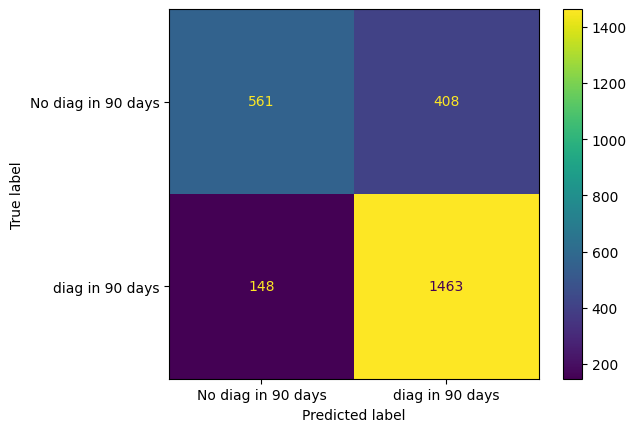

In [49]:
X_train_nobmi = X_train.drop(['bin_bmi'], axis = 1)
X_val_nobmi = X_val.drop(['bin_bmi'], axis = 1)

model.fit(X_train_nobmi, y_train)

predictions_xgb = model.predict(X_val_nobmi)

cm_xgb = confusion_matrix(y_val, predictions_xgb)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['No diag in 90 days', 'diag in 90 days'])
disp.plot()
plt.show()

In [50]:
fi = pd.DataFrame({'feature': list(X_train_nobmi),'importance': 
model.feature_importances_}).sort_values('importance', ascending = False)


with pd.option_context('display.max_rows', None,):
    print(fi)

                             feature  importance
24      breast_cancer_diagnosis_code    0.143557
23                     patient_state    0.037456
25  metastatic_cancer_diagnosis_code    0.030176
27                          Division    0.025993
10                       family_size    0.025842
9                        age_over_80    0.025032
35                             lower    0.024492
13            education_some_college    0.024315
21                      race_pacific    0.023480
20                         sex_ratio    0.023265
22                        payer_type    0.022798
36                             outer    0.022712
17                  health_uninsured    0.022661
15                      age_under_10    0.022634
31                           central    0.022562
33                             inner    0.022484
16                      patient_zip3    0.022441
11                      commute_time    0.022376
4                      housing_units    0.022088
1                   

In [51]:
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import accuracy_score

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [52]:
def objective(space):
    clf=XGBClassifier(enable_categorical = True,
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train_nobmi, y_train), ( X_val_nobmi, y_val)]
    
    clf.fit(X_train_nobmi, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_val_nobmi)
    accuracy = accuracy_score(y_val, pred>0.5)
    #print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [53]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

  1%|          | 1/100 [00:00<00:15,  6.25trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



  3%|▎         | 3/100 [00:00<00:14,  6.52trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



  5%|▌         | 5/100 [00:00<00:14,  6.56trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



  7%|▋         | 7/100 [00:01<00:15,  5.91trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



  9%|▉         | 9/100 [00:01<00:14,  6.21trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 11%|█         | 11/100 [00:01<00:13,  6.49trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 12%|█▏        | 12/100 [00:02<00:16,  5.42trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 14%|█▍        | 14/100 [00:02<00:14,  6.05trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 16%|█▌        | 16/100 [00:02<00:13,  6.34trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 18%|█▊        | 18/100 [00:02<00:12,  6.49trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 20%|██        | 20/100 [00:03<00:12,  6.52trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 22%|██▏       | 22/100 [00:03<00:12,  6.26trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 24%|██▍       | 24/100 [00:03<00:12,  6.17trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 26%|██▌       | 26/100 [00:04<00:12,  6.15trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 28%|██▊       | 28/100 [00:04<00:11,  6.07trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 30%|███       | 30/100 [00:04<00:11,  6.00trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 32%|███▏      | 32/100 [00:05<00:11,  5.98trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 34%|███▍      | 34/100 [00:05<00:11,  5.96trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 36%|███▌      | 36/100 [00:05<00:10,  5.93trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 38%|███▊      | 38/100 [00:06<00:10,  5.93trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 40%|████      | 40/100 [00:06<00:10,  5.94trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 42%|████▏     | 42/100 [00:06<00:09,  5.98trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 44%|████▍     | 44/100 [00:07<00:09,  5.98trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 46%|████▌     | 46/100 [00:07<00:09,  5.88trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 48%|████▊     | 48/100 [00:07<00:08,  5.87trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 50%|█████     | 50/100 [00:08<00:08,  5.91trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 52%|█████▏    | 52/100 [00:08<00:08,  5.91trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 54%|█████▍    | 54/100 [00:08<00:07,  5.92trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 56%|█████▌    | 56/100 [00:09<00:07,  5.86trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 58%|█████▊    | 58/100 [00:09<00:07,  5.77trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 60%|██████    | 60/100 [00:09<00:06,  5.80trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 62%|██████▏   | 62/100 [00:10<00:06,  5.81trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 64%|██████▍   | 64/100 [00:10<00:06,  5.78trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 65%|██████▌   | 65/100 [00:10<00:06,  5.77trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 67%|██████▋   | 67/100 [00:11<00:06,  5.11trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 69%|██████▉   | 69/100 [00:11<00:05,  5.35trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 71%|███████   | 71/100 [00:11<00:05,  5.50trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 73%|███████▎  | 73/100 [00:12<00:04,  5.58trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 75%|███████▌  | 75/100 [00:12<00:04,  5.59trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 77%|███████▋  | 77/100 [00:13<00:04,  5.61trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 79%|███████▉  | 79/100 [00:13<00:03,  5.61trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 81%|████████  | 81/100 [00:13<00:03,  5.58trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 83%|████████▎ | 83/100 [00:14<00:03,  5.58trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 85%|████████▌ | 85/100 [00:14<00:02,  5.57trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 87%|████████▋ | 87/100 [00:14<00:02,  5.58trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 89%|████████▉ | 89/100 [00:15<00:01,  5.55trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 91%|█████████ | 91/100 [00:15<00:01,  5.52trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 93%|█████████▎| 93/100 [00:15<00:01,  5.54trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 95%|█████████▌| 95/100 [00:16<00:00,  5.55trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 97%|█████████▋| 97/100 [00:16<00:00,  5.48trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 99%|█████████▉| 99/100 [00:17<00:00,  5.49trial/s, best loss: -0.6244186046511628]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



100%|██████████| 100/100 [00:17<00:00,  5.81trial/s, best loss: -0.6244186046511628]


In [54]:
best_hyperparams

{'colsample_bytree': 0.6927901101472858,
 'gamma': 4.456440907193917,
 'max_depth': 16.0,
 'min_child_weight': 8.0,
 'reg_alpha': 89.0,
 'reg_lambda': 0.5196849189298384}

In [55]:
model = XGBClassifier(enable_categorical = True,
                      colsample_bytree = 0.9375946185841314, gamma = 2.508389650188689, 
                      max_depth = 13, min_child_weight = 6, reg_alpha = 87, reg_lambda = 0.2840405143661747)

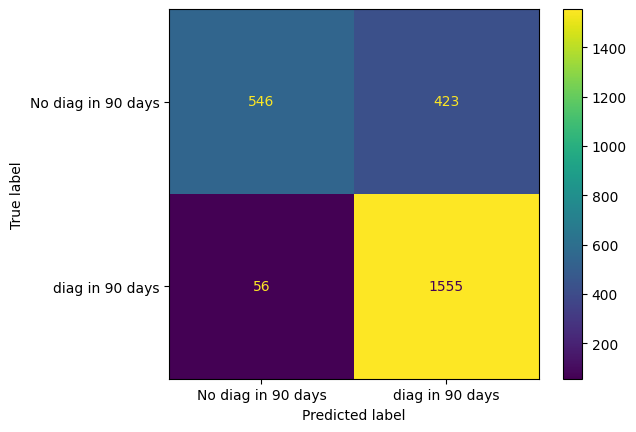

In [56]:
model.fit(X_train_nobmi, y_train)

predictions_xgb = model.predict(X_val_nobmi)

cm_xgb = confusion_matrix(y_val, predictions_xgb)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['No diag in 90 days', 'diag in 90 days'])
disp.plot()
plt.show()

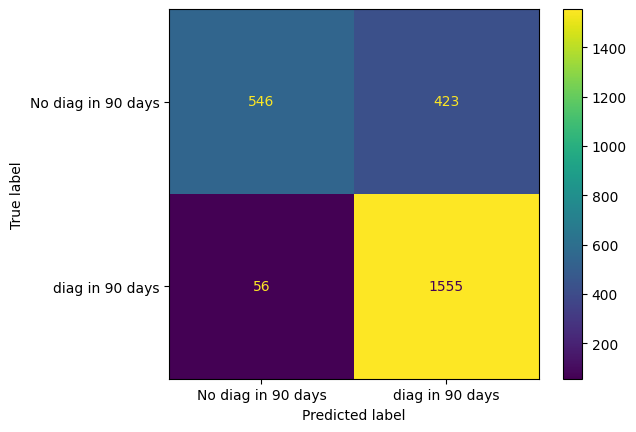

In [57]:
X_train_no_codes = X_train.drop(['metastatic_cancer_diagnosis_code','payer_type'], axis = 1)
X_val_no_codes = X_val.drop(['metastatic_cancer_diagnosis_code','payer_type'], axis = 1)

model.fit(X_train_no_codes, y_train)

predictions_xgb = model.predict(X_val_no_codes)

cm_xgb = confusion_matrix(y_val, predictions_xgb)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['No diag in 90 days', 'diag in 90 days'])
disp.plot()
plt.show()

In [58]:
X_test_nobmi = X_test.drop(['bin_bmi'], axis = 1)

model = XGBClassifier(enable_categorical = True)

model.fit(X_train_nobmi, y_train)
predictions_xgb = model.predict(X_test_nobmi)

In [59]:
test = pd.read_csv("/kaggle/input/widsdatathon2024-challenge1/test.csv")

output = pd.DataFrame({'patient_id': test.patient_id, 'DiagPeriodL90D': predictions_xgb})
output.to_csv('submission.csv', index=False)